In [1]:
#%load_ext autoreload
#%autoreload 2

%pylab inline

import sys
from utils_bosons import * 
from matplotlib import ticker, cm
from glob import glob
import parse
import collections
import math
from scipy import optimize

import multiprocessing
from functools import partial

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 24
    #'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)
matplotlib.rcParams['figure.figsize'] = 8, 4.5

cmap = 'magma'

Populating the interactive namespace from numpy and matplotlib


## Load PSDs

In [2]:
psd_path='./LISA_PSDs/S_h_{model}.txt'
psd_paths=glob(psd_path.format(model='*'))

psd_data={}

for path in psd_paths:
    label = parse.parse(psd_path, path)['model']
    psd_data[label] = np.loadtxt(path)
    
print(psd_data.keys())

dict_keys(['scird_deg2', 'scird_deg1', 'scird'])


In [8]:
psd_data['cbe'] = psd_data['scird'].copy()
psd_data['cbe'][:,1] /= 1.5**2

In [9]:
cbe_data = loadtxt('LISA_PSDs/Sh_CBE_SciRD.dat')

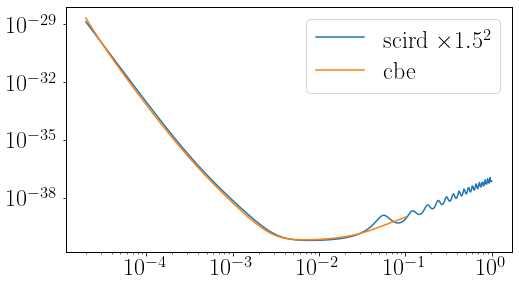

In [10]:
loglog(psd_data['cbe'][:,0], psd_data['cbe'][:,1], label=r'scird $\times 1.5^2$')
loglog(cbe_data[:,0], cbe_data[:,1]/2, label='cbe')
legend();

# Population independent FoM

## Waterfall plot

In [11]:
def get_peak(a, lgw=2, **kwargs): 
    cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, alpha=a, evolve_params={'y_0': 1E-8}, **kwargs) 
    return cloud.gw(lgw).h0r, cloud.gw(lgw).f

In [12]:
alphas = np.arange(0.01, 0.5, 0.01)

chi_bh=0.9 #initial BH spin

# collect peak values
pool = multiprocessing.Pool(8)
h0r_fs = pool.map(partial(get_peak, m_bh=1e5, chi_bh=chi_bh), alphas)

#alpha value that maximizes GW emission should be independent of BH mass
best = max(zip(h0r_fs, alphas))
print("Best alpha for BH spin=%.2f:\n-----------------------" % chi_bh)
print("alpha\t%.2f" % best[1])

Best alpha for BH spin=0.90:
-----------------------
alpha	0.27


In [13]:
noise_key = 'cbe'

logMmin=4
logMmax=9
zmin=0.001
zmax=2.5

chi_bh=chi_bh
alpha=best[1]
lgw=2

fmin=1e-4 #minimum frequency in Hz
Tobs=4.5 #observation time in years
gal=False #whether to include WD galactic foreground in SNR calculation

SNRarray=[]

for z in np.linspace(zmin,zmax, num=200):
    for log10mbh in np.linspace(logMmin, logMmax, num=50):


        cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, alpha=alpha, m_bh=10**log10mbh, chi_bh=chi_bh, 
                                               evolve_params={'y_0': 1E-8})
       
        hgwr, fgw = cloud.gw(lgw).h0r, cloud.gw(lgw).f
        distance=cosmo.comoving_distance(z).value*1e6*gwaxion.PC_SI
        h0=np.sqrt(5/(4*np.pi))*hgwr/distance #see my notes
        hav=h0*np.sqrt(4/5) #see eq. 16 in https://arxiv.org/pdf/1803.01944.pdf
    
        fdetector=fgw/(1+z) #frequency at the detector
        tgw=cloud.get_life_time([lgw,lgw])
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal
        
        SNR=SNRav(hav=hav, f=fdetector,PSD=psd_data[noise_key], tgw=tgwredshift, Tobs = Tobs, gal=gal, fmin=fmin)
        if SNR==0:
            SNR=1e-10 # this is to avoid errors when doing the waterfall plot
        
        SNRarray.append([log10mbh,z,SNR,hav])
        #print(log10mbh,z,SNRav(hav=hav, fdetector=fdetector, PSD=psd_data['scird'], tgw=tgw, Tobs = 4, gal=True))


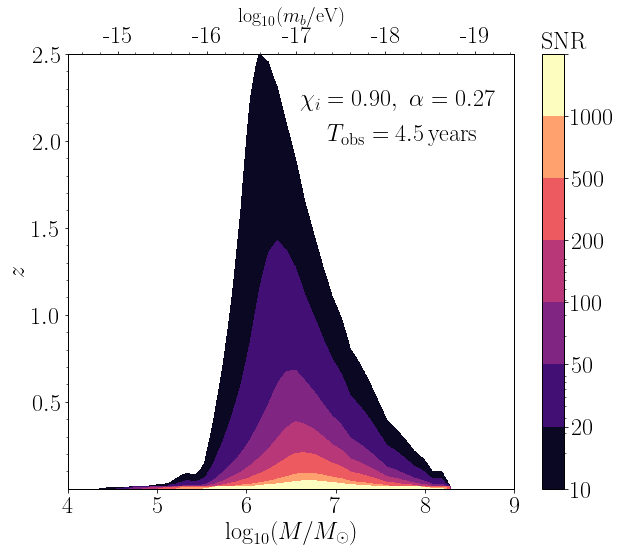

In [14]:
m_b=np.array([1e-15,1e-16,1e-17,1e-18,1e-19])
log10vec=np.vectorize(math.log10)
mass_list = np.array(SNRarray).T[0,:]
redshift_list = np.array(SNRarray).T[1,:]
snr_list = np.array(SNRarray).T[2,:]

rangec =[10,20,50,100,200,500,1000,50000]

fig, ax = plt.subplots(1, figsize=(10,8))
ax2 = ax.twiny()

CS = plt.tricontourf(mass_list, redshift_list, snr_list, 
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator())
cb = plt.colorbar(CS, ticks=rangec)
cb.ax.set_yticklabels(['10', '20', '50','100','200','500','1000',''])  # vertically oriented colorbar
cb.set_label(label=r"SNR", labelpad=-50, y=1.05, rotation=0)

ax.set_xlabel(r"$\log_{10}(M/M_{\odot})$")
ax.set_ylabel(r"$z$")
ax.set_xlim([4,9])
plt.text(6.6, 2.2, r'$\chi_i=%.2f,\,\,\alpha=%.2f $' % (chi_bh, alpha))
plt.text(6.9, 2.0, r'$T_{\rm obs}=%.1f\,{\rm years}$' % Tobs)

ax2.set_xlim(ax.get_xlim())
new_tick_locations = log10vec(alpha*gwaxion.MPL_SI**2/(m_b*gwaxion.EV_SI/gwaxion.C_SI**2)/gwaxion.MSUN_SI)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([-15,-16,-17,-18,-19]) #(list(log10vec(m_b)))
ax2.set_xlabel(r'$\log_{10}(m_b/{\rm eV})$',fontsize=20)

plt.minorticks_on()

plot_file_name = './Plots/waterfall_LISA_fmin10min4_%s.pdf' % noise_key
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

### FoM 1: 

Range of boson masses that can be constrained for sources at a given cosmological redshift $z$, with given initial BH spin $\chi$ and using $\alpha$ that maximizes the GW emission. Here we use: 

$z=0.5$ and $\chi=0.9$. For $\chi=0.9$ the value of $\alpha$ that maximizes GW emission is $\alpha\approx 0.27$ as shown above.

In [15]:
SNRarray=[]

z=0.5 #redshift at which to compute FoM
chi_bh=0.9 #BH spin at which to compute FoM
alpha=best[1]

for log10mbh in np.linspace(logMmin, logMmax, num=50):

    cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, alpha=alpha, m_bh=10**log10mbh, chi_bh=chi_bh, 
                                               evolve_params={'y_0': 1E-8})
    hgwr, fgw = cloud.gw(lgw).h0r, cloud.gw(lgw).f
    distance=cosmo.comoving_distance(z).value*1e6*gwaxion.PC_SI
    h0=np.sqrt(5/(4*np.pi))*hgwr/distance #see notes
    hav=h0*np.sqrt(4/5) #see eq. 16 in https://arxiv.org/pdf/1803.01944.pdf
    
    fdetector=fgw/(1+z) #frequency at the detector
    tgw=cloud.get_life_time([lgw,lgw])
    tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal
        
    SNR=SNRav(hav=hav, f=fdetector,PSD=psd_data[noise_key], tgw=tgwredshift, Tobs = Tobs, gal=gal, fmin=fmin)
         
    SNRarray.append([log10mbh,SNR])

In [16]:
SNRcut=10 #minimum SNR for detection
bounds = interpolate.interp1d(np.array(SNRarray)[:,0],np.array(SNRarray)[:,1]-SNRcut, kind='slinear')
SNRfunc = lambda x: bounds(x)

lower=optimize.newton(SNRfunc, 7.5)
upper=optimize.newton(SNRfunc, 5.5)

lowermb=alpha*gwaxion.MPL_SI**2/(10**lower*gwaxion.MSUN_SI)/(gwaxion.EV_SI/gwaxion.C_SI**2)
uppermb=alpha*gwaxion.MPL_SI**2/(10**upper*gwaxion.MSUN_SI)/(gwaxion.EV_SI/gwaxion.C_SI**2)

print("For Tobs=%.1f years, alpha=%.2f and initial BH spin=%.2f, detectable range (SNR>10) at redshift z=%.2f is:"
      %(Tobs, alpha,chi_bh,z))
print("mb=[%.1e,%.1e] eV"%(lowermb,uppermb))

For Tobs=4.5 years, alpha=0.27 and initial BH spin=0.90, detectable range (SNR>10) at redshift z=0.50 is:
mb=[1.2e-18,7.7e-17] eV


### FoM 2:

Range of boson masses that can be constrained for a reference BH with some initial mass $M$ and spin $\chi$ at a given cosmological redshift. Here we use: 

$z=0.5$, $M=4\times 10^6 M_{\odot}$ (i.e. SgrA$^*$-like) and $\chi=0.9$.

In [17]:
SNRarray=[]

z=.5 #redshift at which to compute FoM
m_bh=4e6 #BH mass at which to compute FoM
chi_bh=0.9 #BH spin at which to compute FoM

Tobs=4.5 #obs time in years
gal=False #whether to include galactic binary foreground
fmin=1e-4 #min freq

for alpha in np.arange(0.01, 0.5, 0.01):

    cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, alpha=alpha, m_bh=m_bh, chi_bh=chi_bh, 
                                               evolve_params={'y_0': 1E-8})
    hgwr, fgw = cloud.gw(lgw).h0r, cloud.gw(lgw).f
    tinst= cloud.number_growth_time

    if tinst>0.:
        distance=cosmo.comoving_distance(z).value*1e6*gwaxion.PC_SI
        h0=np.sqrt(5/(4*np.pi))*hgwr/distance #see notes
        hav=h0*np.sqrt(4/5) #see eq. 16 in https://arxiv.org/pdf/1803.01944.pdf
    
        fdetector=fgw/(1+z) #frequency at the detector
        tgw=cloud.get_life_time([lgw,lgw])
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal
        
        SNR=SNRav(hav=hav, f=fdetector,PSD=psd_data[noise_key], tgw=tgwredshift, Tobs = Tobs, gal=gal, fmin=fmin)
    else:
        SNR=0
    SNRarray.append([alpha,SNR])

In [18]:
SNRcut=10 #minimum SNR for detection
bounds = interpolate.interp1d(np.array(SNRarray)[:,0],np.array(SNRarray)[:,1]-SNRcut, kind='slinear')
SNRfunc = lambda x: bounds(x)

lower=optimize.newton(SNRfunc, 0.2)
upper=optimize.newton(SNRfunc, 0.3)

lowermb=lower*gwaxion.MPL_SI**2/(m_bh*gwaxion.MSUN_SI)/(gwaxion.EV_SI/gwaxion.C_SI**2)
uppermb=upper*gwaxion.MPL_SI**2/(m_bh*gwaxion.MSUN_SI)/(gwaxion.EV_SI/gwaxion.C_SI**2)

print("For Tobs=%.1f years, initial BH mass=%.1e, initial BH spin=%.2f, detectable range (SNR>10) at redshift z=%.2f is:"
      %(Tobs, m_bh,chi_bh,z))
print("mb=[%.1e,%.1e] eV"%(lowermb,uppermb))

For Tobs=4.5 years, initial BH mass=4.0e+06, initial BH spin=0.90, detectable range (SNR>10) at redshift z=0.50 is:
mb=[6.2e-18,1.0e-17] eV


# Population dependent FoM

## Load mass functions

In [19]:
data_path='./BH_population/dnOverdAdLogM_z={redshift}.dat'
paths=glob(data_path.format(redshift='*'))

data_tmp = {}
data = {}

for path in np.sort(paths):
    label = parse.parse(data_path, path)['redshift']
    data_tmp[label] = np.loadtxt(path)
    redshift_col=np.full(len(data_tmp[label]), float(label))
    data[label] = np.column_stack((data_tmp[label], redshift_col))
    data_ord = collections.OrderedDict(data)
    
#put z=0 in first place and stack everything together, at the end columns should be:
#(0) log10M (1) spin (2) redshift (4) dn/(dlog10M dchi)
data_ord.move_to_end('0',last=False)
data_all=np.vstack(list(data_ord.values()))
data_all[:,[2, 3]]=data_all[:,[3, 2]]

## Compute stochastic background

The FoM number for this case is the range of bosons that is detectable (i.e. that give ${\rm SNR}_{\rm back}>10$).

In [20]:
logMmin=min(data_all[:,0])
#logMmax=max(data_all[:,0])
spinmin=0.0
spinmax=0.998
alphamax=0.5 #I use alphamax=0.5 because the maximum alpha=M*mb/Mpl**2 that gives an instability for m=1 is alpha~0.5

OmegaGW_vs_mb={}

for bosonmass in np.logspace(-19, -15, num=20):
    
    logMmax=min(max(data_all[:,0]),
                math.log10(alphamax*gwaxion.MPL_SI**2/(bosonmass*gwaxion.EV_SI/gwaxion.C_SI**2)/gwaxion.MSUN_SI))
    
    lims=[[logMmin, logMmax], [spinmin, spinmax]]

    cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, m_b=bosonmass, alpha=1e-3, chi_bh=0., evolve_params={'y_0': 1E-8}) 
    log10freqmax=math.log10(cloud.gw(2).f/(1+1e-3))
    log10freqmin=math.log10(cloud.gw(2).f/(1+7.))
    
    OmegaGW_vs_mb[bosonmass]=OmegaGW(dn=data_all,m_b=bosonmass,PSD=psd_data[noise_key],intlims=lims,
                                     method='Riemann sum',nsumint=40j
                             ,log10freqmin=log10freqmin,log10freqmax=log10freqmax,num_f=30,printresults=False,gal=False) 
    SNR=SNRback(OmegaGW_vs_mb[bosonmass],psd_data[noise_key],limit=1000)
    
    print('mb=%.2e, SNR=%2.f, fmax=%.2e'%(bosonmass, SNR ,cloud.gw(2).f))


/Users/maxisi/miniconda3/envs/lisa-dm-fom/lib/python3.7/site-packages/gwaxion/physics.py:265: RuntimeWarning: invalid value encountered in sqrt
  self.rp_natural = 1 + np.sqrt(1 - self.chi**2)
/Users/maxisi/miniconda3/envs/lisa-dm-fom/lib/python3.7/site-packages/gwaxion/physics.py:266: RuntimeWarning: invalid value encountered in sqrt
  self.rm_natural = 1 - np.sqrt(1 - self.chi**2)


mb=1.00e-19, SNR= 6, fmax=4.84e-05
mb=1.62e-19, SNR=24, fmax=7.85e-05
mb=2.64e-19, SNR=176, fmax=1.28e-04


/Users/maxisi/papers/lisa-dm-fom/utils_bosons.py:203: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  SNRsq_1s=integrate.quad(integrand, fmin, fmax,**kwargs)


mb=4.28e-19, SNR=393, fmax=2.07e-04
mb=6.95e-19, SNR=1433, fmax=3.36e-04
mb=1.13e-18, SNR=4371, fmax=5.46e-04
mb=1.83e-18, SNR=12744, fmax=8.86e-04
mb=2.98e-18, SNR=30012, fmax=1.44e-03
mb=4.83e-18, SNR=85318, fmax=2.34e-03
mb=7.85e-18, SNR=136477, fmax=3.80e-03
mb=1.27e-17, SNR=120610, fmax=6.16e-03
mb=2.07e-17, SNR=78356, fmax=1.00e-02
mb=3.36e-17, SNR=30421, fmax=1.62e-02
mb=5.46e-17, SNR=9491, fmax=2.64e-02
mb=8.86e-17, SNR=2627, fmax=4.28e-02
mb=1.44e-16, SNR=653, fmax=6.96e-02
mb=2.34e-16, SNR=115, fmax=1.13e-01
mb=3.79e-16, SNR=13, fmax=1.83e-01
mb=6.16e-16, SNR= 1, fmax=2.98e-01
mb=1.00e-15, SNR= 0, fmax=4.84e-01


In [21]:
SNRlist=[]
fmin=1e-4 #set min freq with which to compute SNR
for m_b in OmegaGW_vs_mb.keys():
    if fmin>max(OmegaGW_vs_mb[m_b][:,0]):
        SNR=0
    elif fmin>min(OmegaGW_vs_mb[m_b][:,0]):
        SNR=SNRback(OmegaGW_vs_mb[m_b],psd_data[noise_key],limit=1000,gal=False,fmin=fmin)
    else:
        SNR=SNRback(OmegaGW_vs_mb[m_b],psd_data[noise_key],limit=1000,gal=False)
    SNRlist.append([m_b,SNR])
SNRarray=np.array(SNRlist)

In [37]:
loadtxt('scird_snrfunc.dat', unpack=True)

array([[1.00000000e-19, 1.00926219e-19, 1.01861017e-19, ...,
        9.81729841e-16, 9.90822810e-16, 1.00000000e-15],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.06463423e-01, 1.06463423e-01, 1.06463423e-01]])

In [40]:
import os

Detectable range is m_b=[2.1e-19,4.3e-16]


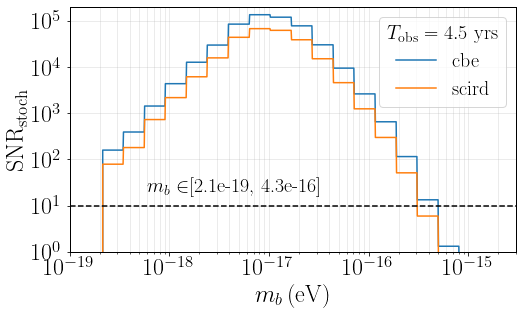

In [44]:
log10vec=np.vectorize(math.log10)

SNRcut=10
SNRint = interpolate.interp1d(-log10vec(SNRarray[:,0]),SNRarray[:,1]-SNRcut, kind='slinear')

SNRfunc = lambda x: SNRint(x)

lower=max(10**-optimize.newton(SNRfunc, 18),fmin*gwaxion.HBAR_SI*np.pi/gwaxion.EV_SI)
upper=10**-optimize.newton(SNRfunc, 16)
print("Detectable range is m_b=[%.1e,%.1e]"%(lower,upper))

#plt.plot(SNRarray[:,0],SNRarray[:,1],'-',label=r'$T_{\rm obs}=4\,{\rm years}$')
SNRfunc = interpolate.interp1d(SNRarray[:,0],SNRarray[:,1], kind='nearest')
mbfunc = np.logspace(-19, -15, num=1000)
plt.plot(mbfunc,SNRfunc(mbfunc), '-', label=noise_key)

ref_path = 'scird_snrfunc.dat'
if noise_key == 'scird':
    savetxt(ref_path, column_stack([mbfunc, SNRfunc(mbfunc)]))
elif os.path.exists(ref_path):
    ref_mbfunc, ref_SNRfunc_mbfunc = loadtxt(ref_path, unpack=True)
    plt.plot(ref_mbfunc, ref_SNRfunc_mbfunc, '-', label='scird')
    

plt.ylim([1e0,2e5])
plt.xlim([1e-19,3e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5])
plt.axhline(y=SNRcut,linestyle='--',c='black')

plt.legend(loc='upper right', fontsize=20, title_fontsize=20,
           title=r'$T_{\rm obs} = %.1f\,\,{\rm yrs}$' % Tobs)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm SNR}_{\rm stoch}$')
plt.text(6e-19, 20,'$m_b\in$[%.1e, %.1e]'%(lower,upper),size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plot_file_name = './Plots/SNR_background_%s.pdf' % noise_key
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

## Compute number of CWs observations *with* confusion noise from stochastic background computed above

The FoM number for this case is the range of bosons that give a nonzero number of GW detections.

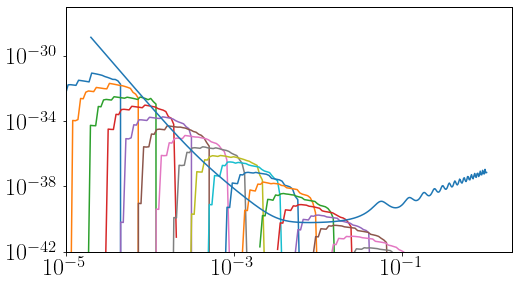

In [23]:
Sconf={}
for m_b in OmegaGW_vs_mb.keys():
    Sconf[m_b] = SfromOmegaGW(OmegaGW_vs_mb[m_b])
    plt.loglog(Sconf[m_b][:,0],Sconf[m_b][:,1])
plt.loglog(psd_data[noise_key][:,0],psd_data[noise_key][:,1])
plt.ylim([1e-42,1e-27])
plt.xlim([1e-5,2e-0])
plt.show()

In [24]:
Sn_mb={}
model=noise_key
for m_b in Sconf.keys():
    Sn_total=[]
    Sn = interpolate.interp1d(psd_data[model][:,0],psd_data[model][:,1])
    Sconfint = interpolate.interp1d(Sconf[m_b][:,0],Sconf[m_b][:,1])
    
    fmin=min(Sconf[m_b][:,0])
    fmax=max(Sconf[m_b][:,0])
  
    for f in psd_data[model][:,0]:
        if f < fmin or f > fmax:
            Sn_total.append([f,Sn(f)])
        else:
            Sn_total.append([f,Sn(f)+Sconfint(f)])
    
    Sn_mb[m_b]=np.array(Sn_total)

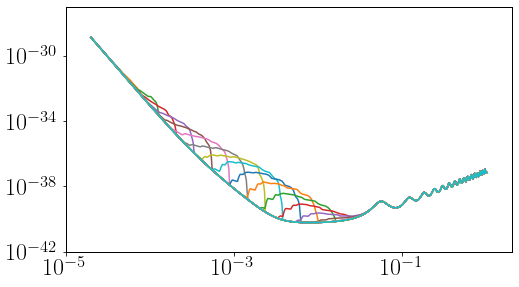

In [25]:
for m_b in OmegaGW_vs_mb.keys():
    plt.loglog(Sn_mb[m_b][:,0],Sn_mb[m_b][:,1])
plt.ylim([1e-42,1e-27])
plt.xlim([1e-5,2e-0])
plt.show()

In [26]:
Nvsmb=[]

#logMmin=4  #min(data_all[:,0])
#logMmax=9 #max(data_all[:,0])

#note that in priciple you can set whatever you want for int limits. 
#but narrowing the limits using some previous knowledge about detectable range 
#helps with decreasing the error of the integration

alphamin=0.01 #set by requiring instability timescale to be smaller than age of the Universe for all masses that we consider. 
alphamax=0.5 #set by maximum alpha=M*mb/Mpl**2 that gives instability for m=1
spinmin=0.0
spinmax=0.998
zmin=0.001
zmax=4 #max(data_all[:,2])
fmin=1e-4  #set min freq with which to compute SNR

for m_b in Sn_mb.keys():
    logMmin=max(min(data_all[:,0]),
                math.log10(alphamin*gwaxion.MPL_SI**2/(m_b*gwaxion.EV_SI/gwaxion.C_SI**2)/gwaxion.MSUN_SI))
    logMmax=min(max(data_all[:,0]),
                math.log10(alphamax*gwaxion.MPL_SI**2/(m_b*gwaxion.EV_SI/gwaxion.C_SI**2)/gwaxion.MSUN_SI))

    lims=[[logMmin, logMmax], [spinmin, spinmax], [zmin, zmax]]
    
    Ntotal=Nevents(dn=data_all,m_b=m_b,PSD=Sn_mb[m_b],intlims=lims,neval=5e3,method='vegas',gal=False,fmin=fmin)
    Nvsmb.append([m_b,Ntotal])
    

/Users/maxisi/miniconda3/envs/lisa-dm-fom/lib/python3.7/site-packages/gwaxion/physics.py:265: RuntimeWarning: invalid value encountered in sqrt
  self.rp_natural = 1 + np.sqrt(1 - self.chi**2)
/Users/maxisi/miniconda3/envs/lisa-dm-fom/lib/python3.7/site-packages/gwaxion/physics.py:266: RuntimeWarning: invalid value encountered in sqrt
  self.rm_natural = 1 - np.sqrt(1 - self.chi**2)


mb=1.00e-19, Nevents=0.00, std=0.00, chisq/dof=0.00, Q=nan
mb=1.62e-19, Nevents=0.00, std=0.00, chisq/dof=0.00, Q=nan
mb=2.64e-19, Nevents=2.74, std=0.05, chisq/dof=4.32, Q=0.00
mb=4.28e-19, Nevents=6.80, std=0.16, chisq/dof=8.80, Q=0.00
mb=6.95e-19, Nevents=30.20, std=0.30, chisq/dof=1.12, Q=0.35
mb=1.13e-18, Nevents=57.81, std=0.54, chisq/dof=0.64, Q=0.77
mb=1.83e-18, Nevents=138.06, std=1.62, chisq/dof=0.78, Q=0.64
mb=2.98e-18, Nevents=494.80, std=4.72, chisq/dof=0.68, Q=0.73
mb=4.83e-18, Nevents=764.42, std=7.22, chisq/dof=1.61, Q=0.11
mb=7.85e-18, Nevents=2147.88, std=27.81, chisq/dof=0.32, Q=0.97
mb=1.27e-17, Nevents=1921.15, std=19.81, chisq/dof=0.95, Q=0.48
mb=2.07e-17, Nevents=2421.75, std=26.41, chisq/dof=0.48, Q=0.89
mb=3.36e-17, Nevents=2127.01, std=19.92, chisq/dof=0.62, Q=0.78
mb=5.46e-17, Nevents=1723.15, std=16.91, chisq/dof=0.79, Q=0.62
mb=8.86e-17, Nevents=650.81, std=5.11, chisq/dof=1.57, Q=0.12
mb=1.44e-16, Nevents=49.44, std=0.41, chisq/dof=3.40, Q=0.00
mb=2.34e-16

Detectable range is m_b=[2.1e-19,3.2e-16]


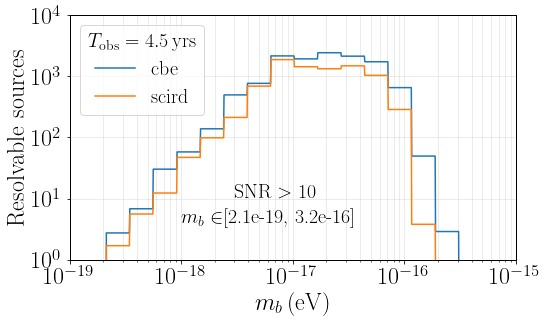

In [47]:
log10vec=np.vectorize(math.log10)
Narray=np.array(Nvsmb)

Ncut=1
Nroot = interpolate.interp1d(-log10vec(Narray[:,0]),Narray[:,1]-Ncut, kind='slinear')

Nrfunc = lambda x: Nroot(x)
mbfunc = np.logspace(-19, -15.5, num=1000)

lower=max(10**-optimize.newton(Nrfunc, 18),fmin*gwaxion.HBAR_SI*np.pi/gwaxion.EV_SI)
upper=10**-optimize.newton(Nrfunc, 16)
print("Detectable range is m_b=[%.1e,%.1e]"%(lower,upper))

Nfunc = interpolate.interp1d(Narray[:,0],Narray[:,1], kind='nearest')
mbfunc = np.logspace(-19, -15.5, num=1000)

#plt.plot(Narray[:,0],Narray[:,1],'-',label=r'$T_{\rm obs}=4\,{\rm years}$')
plt.plot(mbfunc, Nfunc(mbfunc), '-', label=noise_key)

ref_path = 'nfunc_back_scird.dat'
if noise_key == 'scird':
    savetxt(ref_path, column_stack([mbfunc, SNRfunc(mbfunc)]))
elif os.path.exists(ref_path):
    ref_mbfunc, ref_Nfunc_mbfunc = loadtxt(ref_path, unpack=True)
    plt.plot(ref_mbfunc, ref_Nfunc_mbfunc, '-', label='scird')

plt.ylim([1e0,1e4])
plt.xlim([1e-19,1e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4])
#plt.axhline(y=1,linestyle='--',c='black')

plt.legend(loc='upper left', fontsize=20, title_fontsize=20,
          title=r'$T_{\rm obs}=%.1f\,{\rm yrs}$' % Tobs)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm Resolvable\,\, sources}$')
plt.text(3e-18, 10,r'${\rm SNR}>10$',size=20)
plt.text(1e-18, 4,'$m_b\in$[%.1e, %.1e]'%(lower,upper),size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plot_file_name = './Plots/Nevents.pdf'
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

In [53]:
sum(Nfunc(mbfunc) -ref_Nfunc_mbfunc) / sum(ref_Nfunc_mbfunc)

0.4771346502748181

In [50]:
max(Nfunc(mbfunc))/max(ref_Nfunc_mbfunc)

1.2955370981658891

## Compute number of CWs observations *without* confusion noise from stochastic background computed above

This is here for completeness, the figures below are not included in FOM document.

In [28]:
Nvsmb_noback=[]

alphamin=0.01
alphamax=0.5
spinmin=0.0
spinmax=0.998
zmin=0.001
zmax=4
fmin=1e-4

for m_b in Sn_mb.keys():
    logMmin=max(min(data_all[:,0]),
                math.log10(alphamin*gwaxion.MPL_SI**2/(m_b*gwaxion.EV_SI/gwaxion.C_SI**2)/gwaxion.MSUN_SI))
    logMmax=min(max(data_all[:,0]),
                math.log10(alphamax*gwaxion.MPL_SI**2/(m_b*gwaxion.EV_SI/gwaxion.C_SI**2)/gwaxion.MSUN_SI))

    lims=[[logMmin, logMmax], [spinmin, spinmax], [zmin, zmax]]
    
    Ntotal=Nevents(dn=data_all,m_b=m_b,PSD=psd_data[noise_key],intlims=lims,neval=5e3,method='vegas',gal=False,fmin=fmin)
    Nvsmb_noback.append([m_b,Ntotal])

/Users/maxisi/miniconda3/envs/lisa-dm-fom/lib/python3.7/site-packages/gwaxion/physics.py:265: RuntimeWarning: invalid value encountered in sqrt
  self.rp_natural = 1 + np.sqrt(1 - self.chi**2)
/Users/maxisi/miniconda3/envs/lisa-dm-fom/lib/python3.7/site-packages/gwaxion/physics.py:266: RuntimeWarning: invalid value encountered in sqrt
  self.rm_natural = 1 - np.sqrt(1 - self.chi**2)


mb=1.00e-19, Nevents=0.00, std=0.00, chisq/dof=0.00, Q=nan
mb=1.62e-19, Nevents=0.00, std=0.00, chisq/dof=0.00, Q=nan
mb=2.64e-19, Nevents=11.33, std=0.19, chisq/dof=6.25, Q=0.00
mb=4.28e-19, Nevents=39.28, std=0.53, chisq/dof=13.38, Q=0.00
mb=6.95e-19, Nevents=225.51, std=2.74, chisq/dof=0.53, Q=0.85
mb=1.13e-18, Nevents=1215.69, std=11.58, chisq/dof=0.94, Q=0.49
mb=1.83e-18, Nevents=4389.30, std=43.38, chisq/dof=0.70, Q=0.71
mb=2.98e-18, Nevents=19848.14, std=155.11, chisq/dof=0.43, Q=0.92
mb=4.83e-18, Nevents=79372.12, std=609.68, chisq/dof=1.31, Q=0.22
mb=7.85e-18, Nevents=157279.73, std=1345.61, chisq/dof=0.78, Q=0.63
mb=1.27e-17, Nevents=167182.02, std=1024.69, chisq/dof=1.33, Q=0.22
mb=2.07e-17, Nevents=95612.56, std=565.15, chisq/dof=0.69, Q=0.72
mb=3.36e-17, Nevents=44568.14, std=212.69, chisq/dof=0.56, Q=0.83
mb=5.46e-17, Nevents=10891.46, std=53.55, chisq/dof=0.82, Q=0.60
mb=8.86e-17, Nevents=1985.36, std=11.53, chisq/dof=0.57, Q=0.82
mb=1.44e-16, Nevents=104.77, std=0.52, c

Detectable range is m_b=[2.1e-19,3.2e-16]


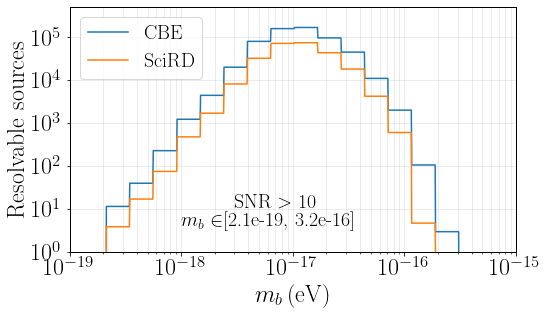

In [34]:
log10vec=np.vectorize(math.log10)
Narray_noback=np.array(Nvsmb_noback)

Ncut=1
Nroot = interpolate.interp1d(-log10vec(Narray_noback[:,0]),Narray_noback[:,1]-Ncut, kind='slinear')

Nrfunc = lambda x: Nroot(x)
mbfunc = np.logspace(-19, -15.5, num=1000)

lower=max(10**-optimize.newton(Nrfunc, 18),fmin*gwaxion.HBAR_SI*np.pi/gwaxion.EV_SI)
upper=10**-optimize.newton(Nrfunc, 16)
print("Detectable range is m_b=[%.1e,%.1e]"%(lower,upper))

Nfunc_noback = interpolate.interp1d(Narray_noback[:,0],Narray_noback[:,1], kind='nearest')
mbfunc = np.logspace(-19, -15.5, num=1000)

#plt.plot(Narray[:,0],Narray[:,1],'-',label=r'$T_{\rm obs}=4\,{\rm years}$')
plt.plot(mbfunc,Nfunc_noback(mbfunc),'-',label='CBE')#r'$T_{\rm obs} = %.1f\,\,{\rm years}$' % Tobs)
Nfunc_noback_scird = loadtxt('nfunc_noback_scird.dat')
plt.plot(mbfunc,Nfunc_noback_scird,'-',label='SciRD')

plt.ylim([1e0,5e5])
plt.xlim([1e-19,1e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5])
#plt.axhline(y=1,linestyle='--',c='black')

plt.legend(loc='upper left',fontsize=20)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm Resolvable\,\, sources}$')
plt.text(3e-18, 10,r'${\rm SNR}>10$',size=20)
plt.text(1e-18, 4,'$m_b\in$[%.1e, %.1e]'%(lower,upper),size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plot_file_name = './Plots/Nevents_noback_%s.pdf' % noise_key
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

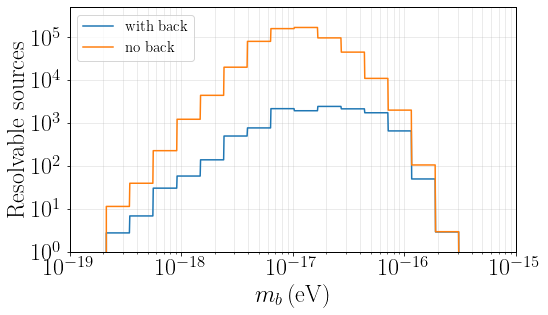

In [31]:
plt.plot(mbfunc,Nfunc(mbfunc),'-',label='with back')
plt.plot(mbfunc,Nfunc_noback(mbfunc),'-',label='no back')

plt.ylim([1e0,5e5])
plt.xlim([1e-19,1e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5])
#plt.axhline(y=1,linestyle='--',c='black')

plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm Resolvable\,\, sources}$')
#plt.text(3e-18, 10,r'${\rm SNR}>10$',size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plt.show()